## Updates
- Change Augmentation
    - `Augmentation in : GaussianBlur, out : Fliplr`

## Mode

In [1]:
DEBUG_MODE = False

## Parameters

In [2]:
# Use or not use
CURATED_ONLY = True # use only curated data for training
USE_CLEAN_NOISY = True # Use clean noisy or dirty noisy
TRAIN_AUGMENT = True # use augmentation for training data?
USE_KERNEL_DATASET = True
MODEL = 'cnn8th' # choose among 'crnn', 'simple', 'cnn8th'

In [3]:
# Config for librosa
SAMPLING_RATE = 44100 # 44.1[kHz]
SAMPLE_DURATION = 2    # 2[sec]
N_MEL = 128  # spectrogram y axis size
HOP_WINDOW = 347
FFT_WINDOW_SIZE = 20

In [4]:
# Spec Augmentation
# Reference: https://www.kaggle.com/davids1992/specaugment-quick-implementation
NUM_MASK = 2
FREQ_MASKING_MAX_PERCENTAGE = 0.15
TIME_MASKING_MAX_PERCENTAGE = 0.30

In [5]:
# Dataset Path
COMPETITION_DATASET_NAME = "freesound-audio-tagging-2019"
PREPROCESSED_DATASET_NAME = "fat2019_prep_mels1"

In [6]:
# Training
BATCH_SIZE = 32
ACTIVATION = 'linear' 
LOSS = 'BCEwithLogits' 
LR = 4e-4
PATIENCE = 9 #ReduceOnPlateau option
LR_FACTOR = 0.75 #ReduceOnPlateau option

In [7]:
# Other configs
SEED = 520
SIZE=128
EPOCHS = [303, 0, 0]
TTA = [19, 0, 0]
checkpoint_file = ['model_best1.h5', 'model_best2.h5', 'model_best3.h5']
VALID_AUGMENT = False
USE_MIXUP = True
MIXUP_PROB = 0.25

# No K-Fold implementation yet
# NUM_K_FOLDS = 5 # how many folds (K) you gonna splits
# NUM_MODEL_RUN = 5 # how many models (<= K) you gonna train [e.g. set to 1 for a simple train/test split]

## Import

In [8]:
# Default
import gc
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import librosa
import sklearn.metrics

from fastprogress import master_bar, progress_bar
from functools import partial
from imgaug import augmenters as iaa
from inspect import currentframe
from numba import jit
from pathlib import Path
from PIL import Image
from psutil import cpu_count
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

# Keras
import tensorflow as tf
import keras
from keras import backend as K
from keras import metrics
from keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobile
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,CSVLogger)
from keras.layers import *
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam 
from keras.utils import Sequence

Using TensorFlow backend.


## Util

In [9]:
# Utility Cell
def chkprint(*args):
    def view_dir(dictionary):
        string = "\n========\n"
        for key, val in dictionary.items():
             string += key + ":\t" + str(val) + "\n"
        string += "--------------\n"
        return string
    names = {id(v):k for k,v in currentframe().f_back.f_locals.items()}
    out =""
    for arg in args:
        attr_name = names.get(id(arg))
        out += attr_name + ": "
        if type(arg) == dict:
            out += view_dir(arg)
        else:
            out += str(arg) + "\n"
    print(out)

In [10]:
def save_as_pkl_binary(obj, filename):
    """Save object as pickle binary file.
    Thanks to https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file/32216025
    """
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def load_pkl(filename):
    """Load pickle object from file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [12]:
IS_KERNEL = ("local" in os.uname()[1]) is False

## Path

In [13]:
ROOT_PATH = Path("..") if IS_KERNEL else  Path(".").absolute().parents[0]
dataset_dir = ROOT_PATH / "input" / COMPETITION_DATASET_NAME
preprocessed_dir = ROOT_PATH / "input" / PREPROCESSED_DATASET_NAME

In [14]:
HEAD = "debug_" if DEBUG_MODE else ""
CURATED_DIR = HEAD + "train_curated"
NOISY_DIR = HEAD + "train_noisy"
TEST_DIR = HEAD + "test"
SAMPLE_SUBMISSION = HEAD + "sample_submission"

In [15]:
csvs = {
    'train_curated': dataset_dir / '{}.csv'.format(CURATED_DIR),
    'train_noisy': dataset_dir / '{}.csv'.format(NOISY_DIR),
    'clean_train_noisy': preprocessed_dir / 'trn_noisy_best50s.csv',
    'sample_submission': dataset_dir / '{}.csv'.format(SAMPLE_SUBMISSION),
}

dataset = {
    'train_curated': dataset_dir / CURATED_DIR,
    'train_noisy': dataset_dir / NOISY_DIR,
    'test': dataset_dir / TEST_DIR,
}

mels = {
    'train_curated': preprocessed_dir / 'mels_train_curated.pkl',
    'train_noisy': preprocessed_dir / 'mels_trn_noisy_best50s.pkl',
}

In [16]:
# Utility Cell
chkprint(dataset_dir, preprocessed_dir, HEAD, csvs, dataset, mels)

dataset_dir: ../input/freesound-audio-tagging-2019
preprocessed_dir: ../input/fat2019_prep_mels1
HEAD: 
csvs: 
train_curated:	../input/freesound-audio-tagging-2019/train_curated.csv
train_noisy:	../input/freesound-audio-tagging-2019/train_noisy.csv
clean_train_noisy:	../input/fat2019_prep_mels1/trn_noisy_best50s.csv
sample_submission:	../input/freesound-audio-tagging-2019/sample_submission.csv
--------------
dataset: 
train_curated:	../input/freesound-audio-tagging-2019/train_curated
train_noisy:	../input/freesound-audio-tagging-2019/train_noisy
test:	../input/freesound-audio-tagging-2019/test
--------------
mels: 
train_curated:	../input/fat2019_prep_mels1/mels_train_curated.pkl
train_noisy:	../input/fat2019_prep_mels1/mels_trn_noisy_best50s.pkl
--------------



## Initialization

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [18]:
DataLoader = partial(DataLoader, num_workers=cpu_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading

In [19]:
train_curated = pd.read_csv(csvs['train_curated'])
noisy_name = "clean_train_noisy" if USE_CLEAN_NOISY else "train_noisy"
train_noisy = pd.read_csv(csvs[noisy_name])
train_df = train_curated
if CURATED_ONLY is False:
    train_df = pd.concat([train_curated, train_noisy], sort=True, ignore_index=True)
test_df = pd.read_csv(csvs['sample_submission'])
labels = test_df.columns[1:].tolist()
num_classes = len(labels)

In [20]:
# Utility Cell
display(train_curated.head(5))
display(train_noisy.head(5))
display(test_df.head(5))
display(labels[:10])
chkprint(num_classes)

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


,fname,labels,singled
0,35688e71.wav,Bathtub_(filling_or_washing),True
1,60d25862.wav,Bathtub_(filling_or_washing),True
2,c0f6fce9.wav,Bathtub_(filling_or_washing),True
3,f3221561.wav,Bathtub_(filling_or_washing),True
4,b2af1dc9.wav,Bathtub_(filling_or_washing),True


,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0012633b.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,001ed5f1.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00294be0.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,003fde7a.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation']

num_classes: 80



In [21]:
y_train = np.zeros((len(train_df), num_classes)).astype(int)
for i, row in enumerate(train_df['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

## Preprocessing
### librosa

In [22]:
def read_audio(wav_path):
    y, _= librosa.load(wav_path, sr=SAMPLING_RATE)

    # trim silence : https://librosa.github.io/librosa/generated/librosa.effects.trim.html
    if 0 < len(y):
        y, _ = librosa.effects.trim(y)

    # padding short data
    sample_size = SAMPLE_DURATION * SAMPLING_RATE
    if len(y) < sample_size:
        padding = sample_size - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, sample_size - len(y) - offset), "constant")

    return y  # np.ndarrya, shape=(sample_size,)

In [23]:
def audio_to_melspectrogram(audio, sr=SAMPLING_RATE):
    spectrogram = librosa.feature.melspectrogram(
        audio,
        sr=sr,
        n_mels=N_MEL,           # https://librosa.github.io/librosa/generated/librosa.filters.mel.html#librosa.filters.mel
        hop_length= SAMPLE_DURATION * HOP_WINDOW,  # to make time steps 128
        n_fft=N_MEL * FFT_WINDOW_SIZE,
        fmin=20,                # Filterbank lowest frequency, Audible range 20[Hz]
        fmax=sr / 2             # Nyquist frequency
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [24]:
def mono_to_color(mono):
    # stack X as [mono, mono, mono]
    x = np.stack([mono, mono, mono], axis=-1)

    # Standardize
    x_std = (x - x.mean()) / (x.std() + 1e-6)

    if (x_std.max() - x_std.min()) > 1e-6:
        color = 255 * (x_std - x_std.min()) / (x_std.max() - x_std.min())
        color = color.astype(np.uint8)
    else:
        color = np.zeros_like(x_std, dtype=np.uint8)

    return color

In [25]:
def read_as_melspectrogram(pathname):
    x = read_audio(pathname)
    return audio_to_melspectrogram(x)

In [26]:
def convert_wav_to_image(df, source):
    X = []
    for i, row in df.iterrows():
        x = read_as_melspectrogram(source / str(row.fname))
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

In [27]:
def create_best_50s_noisy(x_noisy):
    df = x_noisy.copy()
    df['singled'] = ~df.labels.str.contains(',')
    singles_df = df[df.singled]
    
    cat_gp = (singles_df.groupby(
        ['labels']).agg({
        'fname':'count'
    }).reset_index()).set_index('labels')
    labels = singles_df.labels.unique()
    
    idxes_best50s = np.array([random.choices(singles_df[(singles_df.labels == l)].index, k=50) for l in labels]).ravel()
    best50s_df = singles_df.loc[idxes_best50s]
    return best50s_df

### concat curated and noisy data

In [28]:
x_test =  convert_wav_to_image(test_df, dataset["test"])

In [29]:
# Use kernel data
with open(mels['train_curated'], 'rb') as curated, open(mels['train_noisy'], 'rb') as noisy:
    x_train = pickle.load(curated)
    if CURATED_ONLY == False:
        x_train.extend(pickle.load(noisy))

In [30]:
if USE_KERNEL_DATASET:
    x_train = load_pkl(mels["train_curated"])
    if CURATED_ONLY == False:
        x_train.extend(load_pkl(mels["train_noisy"]))
else:
    x_trainn = convert_wav_to_image(train_curated)
    if CURATED_ONLY == False:
        x_noisy = convert_wav_to_image(train_noisy)
        x_train.extend(x_noisy)

In [31]:
# Utility Cell
print("y_train.shape: {}".format(y_train.shape))
print("length of x_train: {}".format(len(x_train)))

y_train.shape: (4970, 80)
length of x_train: 4970


## Training
### Definition of Keras functions

In [32]:
# from https://www.kaggle.com/rio114/keras-cnn-with-lwlrap-evaluation/
def tf_one_sample_positive_class_precisions(y_true, y_pred) :
    num_samples, num_classes = y_pred.shape
    
    # find true labels
    pos_class_indices = tf.where(y_true > 0) 
    
    # put rank on each element
    retrieved_classes = tf.nn.top_k(y_pred, k=num_classes).indices
    sample_range = tf.zeros(shape=tf.shape(tf.transpose(y_pred)), dtype=tf.int32)
    sample_range = tf.add(sample_range, tf.range(tf.shape(y_pred)[0], delta=1))
    sample_range = tf.transpose(sample_range)
    sample_range = tf.reshape(sample_range, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_classes = tf.reshape(retrieved_classes, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_class_map = tf.concat((sample_range, retrieved_classes), axis=0)
    retrieved_class_map = tf.transpose(retrieved_class_map)
    retrieved_class_map = tf.reshape(retrieved_class_map, (tf.shape(y_pred)[0], num_classes, 2))
    
    class_range = tf.zeros(shape=tf.shape(y_pred), dtype=tf.int32)
    class_range = tf.add(class_range, tf.range(num_classes, delta=1))
    
    class_rankings = tf.scatter_nd(retrieved_class_map,
                                          class_range,
                                          tf.shape(y_pred))
    
    #pick_up ranks
    num_correct_until_correct = tf.gather_nd(class_rankings, pos_class_indices)

    # add one for division for "presicion_at_hits"
    num_correct_until_correct_one = tf.add(num_correct_until_correct, 1) 
    num_correct_until_correct_one = tf.cast(num_correct_until_correct_one, tf.float32)
    
    # generate tensor [num_sample, predict_rank], 
    # top-N predicted elements have flag, N is the number of positive for each sample.
    sample_label = pos_class_indices[:, 0]   
    sample_label = tf.reshape(sample_label, (-1, 1))
    sample_label = tf.cast(sample_label, tf.int32)
    
    num_correct_until_correct = tf.reshape(num_correct_until_correct, (-1, 1))
    retrieved_class_true_position = tf.concat((sample_label, 
                                               num_correct_until_correct), axis=1)
    retrieved_pos = tf.ones(shape=tf.shape(retrieved_class_true_position)[0], dtype=tf.int32)
    retrieved_class_true = tf.scatter_nd(retrieved_class_true_position, 
                                         retrieved_pos, 
                                         tf.shape(y_pred))
    # cumulate predict_rank
    retrieved_cumulative_hits = tf.cumsum(retrieved_class_true, axis=1)

    # find positive position
    pos_ret_indices = tf.where(retrieved_class_true > 0)

    # find cumulative hits
    correct_rank = tf.gather_nd(retrieved_cumulative_hits, pos_ret_indices)  
    correct_rank = tf.cast(correct_rank, tf.float32)

    # compute presicion
    precision_at_hits = tf.truediv(correct_rank, num_correct_until_correct_one)

    return pos_class_indices, precision_at_hits

In [33]:
def tf_lwlrap(y_true, y_pred):
    num_samples, num_classes = y_pred.shape
    pos_class_indices, precision_at_hits = (tf_one_sample_positive_class_precisions(y_true, y_pred))
    pos_flgs = tf.cast(y_true > 0, tf.int32)
    labels_per_class = tf.reduce_sum(pos_flgs, axis=0)
    weight_per_class = tf.truediv(tf.cast(labels_per_class, tf.float32),
                                  tf.cast(tf.reduce_sum(labels_per_class), tf.float32))
    sum_precisions_by_classes = tf.zeros(shape=(num_classes), dtype=tf.float32)  
    class_label = pos_class_indices[:,1]
    sum_precisions_by_classes = tf.unsorted_segment_sum(precision_at_hits,
                                                        class_label,
                                                       num_classes)
    labels_per_class = tf.cast(labels_per_class, tf.float32)
    labels_per_class = tf.add(labels_per_class, 1e-7)
    per_class_lwlrap = tf.truediv(sum_precisions_by_classes,
                                  tf.cast(labels_per_class, tf.float32))
    out = tf.cast(tf.tensordot(per_class_lwlrap, weight_per_class, axes=1), dtype=tf.float32)
    return out

In [34]:
def BCEwithLogits(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=True), axis=-1)

## Definition of models

In [35]:
def conv_simple_block(x, n_filters):
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D()(x)
    return x

In [36]:
def create_model_simplecnn(n_out=num_classes):
    inp = Input(shape=(128,128,3))
    # np = Input(shape=(None,None,3))
    x = conv_simple_block(inp,64)
    x = conv_simple_block(x,128)
    x = conv_simple_block(x,256)
    x = conv_simple_block(x,128)
    
    # x1 = GlobalAveragePooling2D()(x)
    # x2 = GlobalMaxPooling2D()(x)
    # x = Add()([x1,x2])

    x = Flatten()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='linear')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    model = Model(inputs=inp, outputs=predictions)
    return model

In [37]:
def output_of_lambda(input_shape):
    return (input_shape[0], input_shape[2], input_shape[3])

def my_max(x):
    return K.max(x, axis=1, keepdims=False)

def crnn_simple_block(x, n_filters):
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = Activation("relu")(x)
    x = Convolution2D(n_filters, (3,1), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    return x

def create_model_crnn(n_out= num_classes):
    
    # inp = Input(shape=(128,128,3))
    inp = Input(shape=(128,None,3))
    x = crnn_simple_block(inp,64)
    x = crnn_simple_block(x,128)
    x = crnn_simple_block(x,256)
    
    # eliminate the frequency dimension, x = (batch, time, channels)
    x = Lambda(my_max, output_shape=output_of_lambda)(x)
    
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    #  x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='linear')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(n_out, activation=ACTIVATION)(x)

    model = Model(inputs=inp, outputs=predictions)
    return model

In [38]:
# from the 8th solution in 2018 competition
# https://github.com/sainathadapa/kaggle-freesound-audio-tagging
def create_model_cnn8th(n_out=num_classes):
    regu=0
    inp = Input(shape=(128,128,3))

    x = Conv2D(48, 11,  strides=(1,1),kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(inp)
    x = BatchNormalization()(x)
    x = Conv2D(48, 11,  strides=(2,3),kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(x)
    x = MaxPooling2D(3, strides=(1,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, 5, strides=(1,1),kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, 5, strides=(2,3),kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(x)
    x = MaxPooling2D(3, strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(192, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(192, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same',kernel_regularizer=regularizers.l2(regu))(x)
    x = MaxPooling2D(3, strides=(1,2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(n_out, activation=ACTIVATION)(x)

    model = Model(inputs=inp, outputs=predictions)
    return model

In [39]:
K.clear_session()
preprocess_input = preprocess_mobile
if MODEL == 'crnn':
    model = create_model_crnn(n_out=num_classes)
elif MODEL == 'cnn8th':
    model = create_model_cnn8th(n_out=num_classes)
else:
    model = create_model_simplecnn(n_out=num_classes)

print(MODEL)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
cnn8th
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 48)      17472     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 48)      192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 43, 48)        278832    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 21, 48)        0         
_________________________________________________________________
batch_normaliz

## Augmentation

In [40]:
def spec_augment(spec: np.ndarray, num_mask=2,
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):
    """Simple augmentation using cross masks
    Reference: https://www.kaggle.com/davids1992/specaugment-quick-implementation
    """
    spec = spec.copy()

    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0

    return spec

In [41]:
augment_img = iaa.Sequential([
    # iaa.ContrastNormalization((0.9, 1.1)),
    # iaa.Multiply((0.9, 1.1), per_channel=0.2),
    # iaa.Fliplr(0.5),
    iaa.GaussianBlur(sigma=(0, 0.1)),
    # iaa.Affine( # x-shift
    #     translate_percent={"x": (-0.1, 0.1), "y": (-0.0, 0.0)},
    #  ),
    iaa.CoarseDropout(0.12,size_percent=0.05) # see examples : https://github.com/aleju/imgaug
], random_order=True)

In [42]:
class FATTrainDataset(Sequence):

    def mix_up(x, y):
        x = np.array(x, np.float32)
        lam = np.random.beta(1.0, 1.0)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y
    
    def getitem(image):
        # crop 2sec

        base_dim, time_dim, _ = image.shape
        crop = random.randint(0, time_dim - base_dim)
        image = image[:,crop:crop+base_dim,:]

        image = preprocess_input(image)
        # label = self.labels[idx]
        return image

    def create_generator(train_X, train_y, batch_size, shape, augument=False, shuffling=False, test_data=False, mixup=False, mixup_prob=0.3):
        assert shape[2] == 3
        while True:
            if shuffling:
                train_X,train_y = shuffle(train_X,train_y)

            for start in range(0, len(train_y), batch_size):
                end = min(start + batch_size, len(train_y))
                batch_images = []
                X_train_batch = train_X[start:end]
                if test_data == False:
                    batch_labels = train_y[start:end]
                
                for i in range(len(X_train_batch)):
                    image = FATTrainDataset.getitem(X_train_batch[i])   
                    if augument:
                        image = FATTrainDataset.augment(image)
                    batch_images.append(image)
                
                if (mixup and test_data == False):
                    dice = np.random.rand(1)
                    if dice > mixup_prob:
                        batch_images, batch_labels =  FATTrainDataset.mix_up(batch_images, batch_labels)    
                    
                if test_data == False:
                    yield np.array(batch_images, np.float32), batch_labels
                else:
                    yield np.array(batch_images, np.float32)
        return image
    
    def augment(image):
        image_aug = augment_img.augment_image(image)
        return image_aug

In [43]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_tf_lwlrap', factor=LR_FACTOR, patience=PATIENCE, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-5 )
checkpoint = ModelCheckpoint(checkpoint_file[0], monitor='val_tf_lwlrap', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
callbacks_list = [checkpoint, reduceLROnPlat]

In [44]:
# split data into train, valid
x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=SEED)

# create train and valid datagens
train_generator = FATTrainDataset.create_generator(
    x_trn, y_trn, BATCH_SIZE, (SIZE,SIZE,3), augument=TRAIN_AUGMENT, shuffling=True, mixup = USE_MIXUP, mixup_prob = MIXUP_PROB)
validation_generator = FATTrainDataset.create_generator(
    x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=VALID_AUGMENT, shuffling=False)

In [45]:
train_steps = np.ceil(float(len(x_trn)) / float(BATCH_SIZE))
val_steps = np.ceil(float(len(x_val)) / float(BATCH_SIZE))
train_steps = train_steps.astype(int)
val_steps = val_steps.astype(int)
print(train_steps, val_steps)
print(len(x_trn))

125 32
3976


In [46]:
print(LOSS)
if LOSS=='BCEwithLogits':
     model.compile(loss=BCEwithLogits,
            optimizer=Adam(lr=LR),
            metrics=[tf_lwlrap,'categorical_accuracy'])
else:
    model.compile(loss=LOSS,
            optimizer=Adam(lr=LR),
            metrics=[tf_lwlrap,'categorical_accuracy'])

BCEwithLogits


In [47]:
print(LR, PATIENCE, LR_FACTOR,BATCH_SIZE, TRAIN_AUGMENT, USE_MIXUP, MIXUP_PROB)

0.0004 9 0.75 32 True True 0.25


In [48]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=EPOCHS[0],
    verbose=1,
    callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/303
125/125 [==============================] - 14s 113ms/step - loss: 0.1963 - tf_lwlrap: 0.1062 - categorical_accuracy: 0.0180 - val_loss: 0.0812 - val_tf_lwlrap: 0.1405 - val_categorical_accuracy: 0.0473

Epoch 00001: val_tf_lwlrap improved from -inf to 0.14047, saving model to model_best1.h5
Epoch 2/303
125/125 [==============================] - 11s 88ms/step - loss: 0.0949 - tf_lwlrap: 0.1140 - categorical_accuracy: 0.0183 - val_loss: 0.0785 - val_tf_lwlrap: 0.1939 - val_categorical_accuracy: 0.0956

Epoch 00002: val_tf_lwlrap improved from 0.14047 to 0.19388, saving model to model_best1.h5
Epoch 3/303
125/125 [==============================] - 11s 87ms/step - loss: 0.0891 - tf_lwlrap: 0.1259 - categorical_accuracy: 0.0252 - val_loss: 0.0728 - val_tf_lwlrap: 0.2144 - val_categorical_accuracy: 0.1006

Epoch 00003: val_tf_lwlrap improved from 0.19388 to 0.21444, saving model to model_best1.h5
Epoch 4/303
125/125 [===============

In [49]:
print(K.eval(model.optimizer.lr))

1e-05


In [50]:
if EPOCHS[1] > 0:
    checkpoint = ModelCheckpoint(checkpoint_file[1], monitor='val_tf_lwlrap', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
    callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]
    
    hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=EPOCHS[1],
    verbose=1,
    callbacks=callbacks_list)

In [51]:
print(K.eval(model.optimizer.lr))

1e-05


In [52]:
if EPOCHS[2] > 0:
    checkpoint = ModelCheckpoint(checkpoint_file[2], monitor='val_tf_lwlrap', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
    callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]
    
    hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=EPOCHS[2],
    verbose=1,
    callbacks=callbacks_list)

In [53]:
print(K.eval(model.optimizer.lr))

1e-05


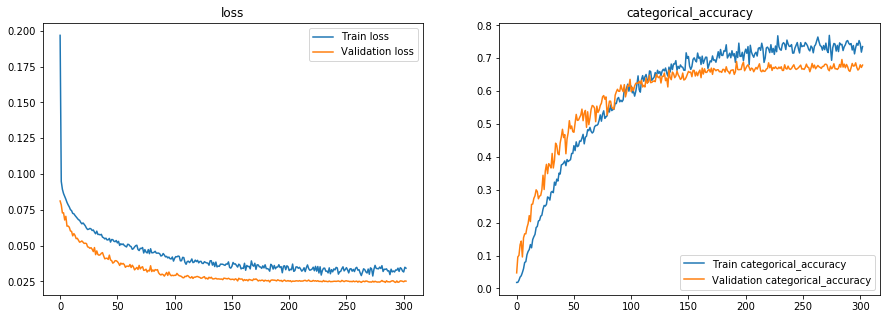

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('categorical_accuracy')
ax[1].plot(hist.epoch, hist.history["categorical_accuracy"], label="Train categorical_accuracy")
ax[1].plot(hist.epoch, hist.history["val_categorical_accuracy"], label="Validation categorical_accuracy")
ax[0].legend()
ax[1].legend()

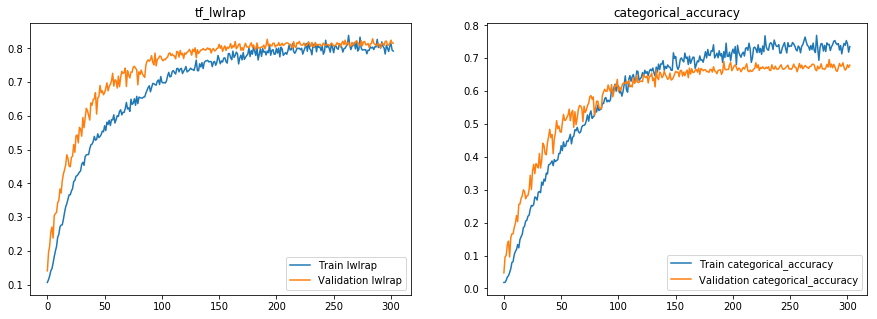

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('tf_lwlrap')
ax[0].plot(hist.epoch, hist.history["tf_lwlrap"], label="Train lwlrap")
ax[0].plot(hist.epoch, hist.history["val_tf_lwlrap"], label="Validation lwlrap")
ax[1].set_title('categorical_accuracy')
ax[1].plot(hist.epoch, hist.history["categorical_accuracy"], label="Train categorical_accuracy")
ax[1].plot(hist.epoch, hist.history["val_categorical_accuracy"], label="Validation categorical_accuracy")
ax[0].legend()
ax[1].legend()

In [56]:
model.load_weights(checkpoint_file[0])

validation_generator = FATTrainDataset.create_generator(
      x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)
pred_val_y = model.predict_generator(validation_generator,steps=val_steps,verbose=1)

for kk in range(len(TTA)):
    
    for ii in range(TTA[kk]):
        validation_generator = FATTrainDataset.create_generator(
          x_val, y_val, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)
        
        pred_val_y += model.predict_generator(validation_generator,steps=val_steps,verbose=1)
    
    if kk+1 < len(TTA) and TTA[kk+1] > 0:
        model.load_weights(checkpoint_file[kk+1])

32/32 [==============================] - 1s 22ms/step


In [57]:
train_generator = FATTrainDataset.create_generator(
    x_trn, y_trn, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False)
pred_train_y = model.predict_generator(train_generator,steps=train_steps,verbose=1)

125/125 [==============================] - 3s 22ms/step


In [58]:
def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
      truth[nonzero_weight_sample_indices, :] > 0, 
      scores[nonzero_weight_sample_indices, :], 
      sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

In [59]:
print("lwlrap from sklearn.metrics for training data =", calculate_overall_lwlrap_sklearn(y_trn, pred_train_y))
print("val lwlrap from sklearn.metrics =", calculate_overall_lwlrap_sklearn(y_val, pred_val_y/10))

score, weight = calculate_per_class_lwlrap(y_val, pred_val_y)
lwlrap = (score * weight).sum()
print('direct calculation of val lwlrap : %.4f' % (lwlrap))

lwlrap from sklearn.metrics for training data = 0.9688745716872545
val lwlrap from sklearn.metrics = 0.8204852345561273


NameError: name 'calculate_per_class_lwlrap' is not defined

## Simple Error Analysis

In [60]:
idx = np.sum(y_val,axis=1) > 1
print(y_val[idx, :].shape, y_val[idx==False, :].shape)

print("val lwlrap for multi-labels =", calculate_overall_lwlrap_sklearn(y_val[idx], pred_val_y[idx]))
print("val lwlrap for single-label =", calculate_overall_lwlrap_sklearn(y_val[idx==False], pred_val_y[idx==False]))

(125, 80) (869, 80)
val lwlrap for multi-labels = 0.8062598940084081
val lwlrap for single-label = 0.8247250080910628


## Predict Test Data with TTA

In [61]:
test_steps = np.ceil(float(len(x_test)) / float(BATCH_SIZE)).astype(int)

In [62]:
model.load_weights(checkpoint_file[0])

test_generator = FATTrainDataset.create_generator(
    x_test, x_test, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False, test_data=True)
pred_test_y = model.predict_generator(test_generator,steps=test_steps,verbose=1)

for kk in range(len(TTA)):
    for ii in range(TTA[kk]):
        test_generator = FATTrainDataset.create_generator(
        x_test, x_test, BATCH_SIZE, (SIZE,SIZE,3), augument=False, shuffling=False, test_data=True)
        
        pred_test_y += model.predict_generator(test_generator,steps=test_steps,verbose=1)
    
    if kk+1 < len(TTA) and TTA[kk+1] > 0:
        model.load_weights(checkpoint_file[kk+1])

35/35 [==============================] - 1s 23ms/step


In [63]:
sort_idx = np.argsort(labels).astype(int)
print(sort_idx)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]


In [64]:
sample_sub = pd.read_csv('../input/freesound-audio-tagging-2019/sample_submission.csv')
test_Y_sort = pred_test_y[:, sort_idx]
sample_sub.iloc[:, 1:] =  test_Y_sort
sample_sub.to_csv('submission.csv', index=False)

sample_sub.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,-127.045609,-150.983688,-151.600006,-146.772339,-177.248032,-64.681175,-151.189865,-150.695312,-112.409966,-157.692139,-144.769485,-155.881943,-173.186066,-142.664520,-133.446823,-152.138092,-163.718872,-147.393814,-156.342880,-131.708359,-158.320587,-147.073334,-111.558578,-143.565689,-168.542755,-84.692215,-166.674591,-164.264328,-144.959534,-140.258453,-112.378075,-153.225998,-150.035980,-184.115997,-87.628639,-135.821503,-173.569122,-147.733490,-159.183685,...,-122.933640,3.896685,-53.301689,-62.143463,-164.043854,-154.190948,-160.101654,-169.661240,-152.192673,-171.788116,-137.792938,-158.177979,-166.852005,-168.507706,-140.640900,-149.391052,-145.599686,-6.965182,-158.601776,-119.793518,-159.735687,-144.114883,-197.327606,-144.131790,-136.231232,-155.983612,-201.138275,-153.834549,-163.364471,-136.135422,-145.522308,-174.234955,-216.920868,-168.343399,-144.652374,-153.281265,-132.439285,-111.639565,-162.119141,-167.247314
1,0012633b.wav,-13.368758,-139.555313,-119.571602,-121.471085,-118.861099,-113.292381,-67.446861,-106.103943,-161.561844,-112.295792,-85.007187,-87.473831,-59.766678,-129.257065,-118.710281,-126.595047,-141.732132,-134.800949,-127.845055,-143.868942,-118.647797,-105.089348,-148.871094,-116.784233,-112.268494,-136.813980,-142.486710,-85.270660,-132.910782,-108.389755,-126.171730,-114.934242,-128.518677,-105.195564,-155.278900,-110.631683,-131.157043,-174.124527,-110.674950,...,-130.024384,-122.944778,-73.451614,-137.316620,-134.614410,-123.901917,-120.782646,-134.052277,-72.839500,-123.633247,-87.683739,-6.899538,-107.519997,-78.853241,-57.455971,-148.283432,-106.870491,-127.899132,-129.794205,-135.872543,-101.544319,-95.695831,-115.697853,-103.985291,-130.046448,-109.155098,-102.682556,-117.607170,-136.981659,-147.296646,-89.079353,-72.729065,-149.650330,-106.258194,-97.806381,-86.081932,-142.666245,-119.589050,-139.431335,-70.540810
2,001ed5f1.wav,-91.631500,-106.753624,-123.380676,-88.851234,-111.642685,-77.945518,-120.412216,-95.046074,-122.434990,-123.088371,-87.650963,-102.671539,-105.473579,-92.285507,-96.009743,-121.861595,-106.962227,-120.111794,-103.068672,-81.341461,-75.863632,-84.483597,-116.638168,-94.323982,-96.919228,-115.210106,-92.224205,-96.749802,-107.110153,-106.358643,-125.496109,-119.168503,-114.852676,-134.515945,-92.102196,-84.707771,-146.714005,-125.846596,-115.275284,...,-116.117928,-92.791794,-99.697365,-114.639755,-76.281609,-99.578293,-97.197998,-118.021416,-90.786362,-122.477966,-83.897247,-96.261238,-79.567986,-124.733269,-98.628479,-110.191116,-4.142453,-86.302162,-126.931778,-108.288170,-137.282700,-108.322639,-88.503670,-89.329300,-118.074249,-80.998177,-83.642258,-124.787071,-43.624569,-97.153656,-99.342300,-95.033447,-148.377747,-51.457783,-107.423065,-82.765175,-114.253311,-92.944626,-118.259697,-103.699051
3,00294be0.wav,-152.483887,-236.094666,-211.856583,-251.093552,-129.081055,-153.859238,-119.54814